In [1]:
import pandas as pd

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller


In [2]:
data = pd.read_csv('BITRE_Fatality-Table 1.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_1065/1511047806.py:1: DtypeWarning: Columns (10,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('BITRE_Fatality-Table 1.csv')


,Crash ID,State,Month,Year,Dayweek,Time,Crash Type,Bus Involvement,Heavy Rigid Truck Involvement,Articulated Truck Involvement,...,Age,National Remoteness Areas,SA4 Name 2021,National LGA Name 2021,National Road Type,Christmas Period,Easter Period,Age Group,Day of week,Time of day
0,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,19,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
1,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,9,NaN,NaN,NaN,NaN,No,No,0_to_16,Weekday,Night
2,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,21,NaN,NaN,NaN,NaN,No,No,17_to_25,Weekday,Night
3,20245021,WA,4,2024,Friday,00:31,Single,No,No,No,...,45,NaN,NaN,NaN,NaN,No,No,40_to_64,Weekday,Night
4,20243023,Qld,4,2024,Friday,01:00,Single,No,No,No,...,24,Outer Regional Australia,Cairns,Cairns,Local Road,No,No,17_to_25,Weekday,Night


In [3]:
data['Gender'].value_counts()

Male           40208
Female         15786
-9                28
U                  2
M                  1
Unspecified        1
Name: Gender, dtype: int64

23:21:59 - cmdstanpy - INFO - Chain [1] start processing
23:21:59 - cmdstanpy - INFO - Chain [1] done processing
23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:00 - cmdstanpy - INFO - Chain [1] done processing
23:22:00 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing


Skipping Unspecified due to insufficient data.
Skipping M  due to insufficient data.
Skipping U due to insufficient data.
Evaluation Metrics for the Test Period (2023) - Gender:
Female - MAE: 3.86, MSE: 26.34, MAPE: 13.62%
Forecast vs Actual for first three months of 2024 for Female:
            ds   yhat  yhat_lower  yhat_upper
420 2024-01-01  21.69        9.44       33.40
421 2024-02-01  18.75        6.31       31.46
422 2024-03-01  25.43       12.89       37.10
        Date  Counts
0 2024-01-01      21
1 2024-02-01      31
2 2024-03-01      25

Forecast for Female in 2030:
            ds   yhat  yhat_lower  yhat_upper
493 2030-01-31  15.40        2.84       28.52
494 2030-02-28  25.58       13.00       39.00
495 2030-03-31  15.90        3.56       27.67
496 2030-04-30  19.04        6.47       30.25
497 2030-05-31  15.11        2.98       27.84
498 2030-06-30  24.37       11.50       36.26
499 2030-07-31  20.14        7.75       32.42
500 2030-08-31  17.04        5.83       29.18
501

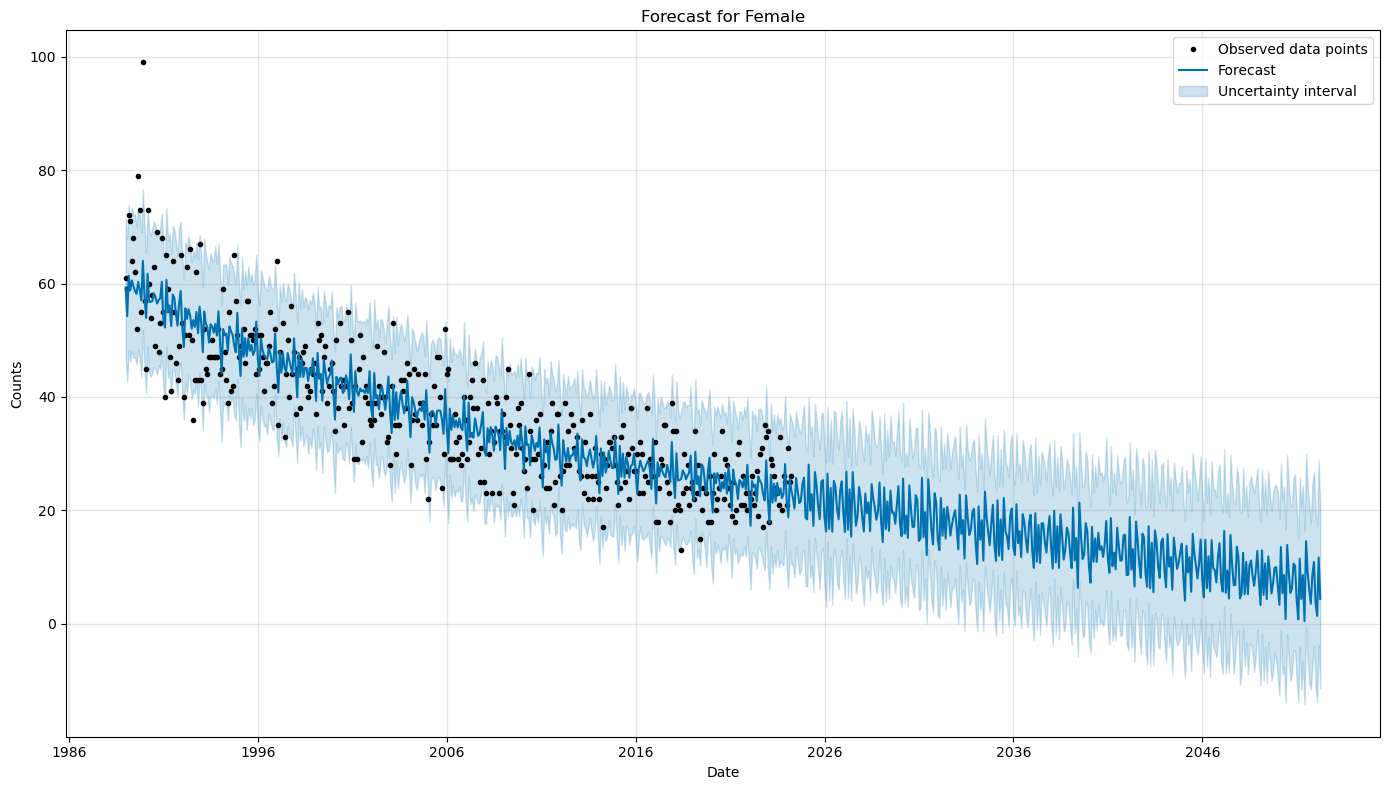

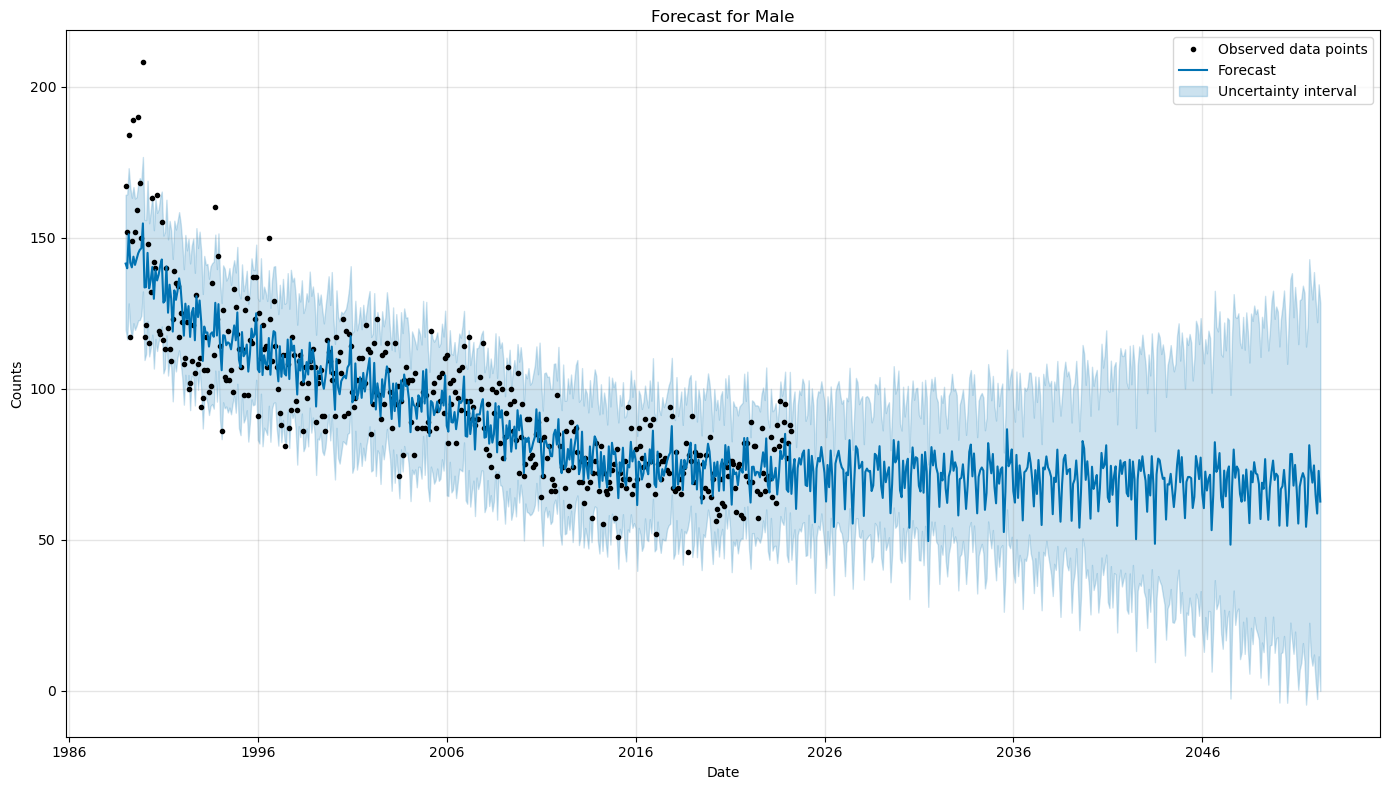

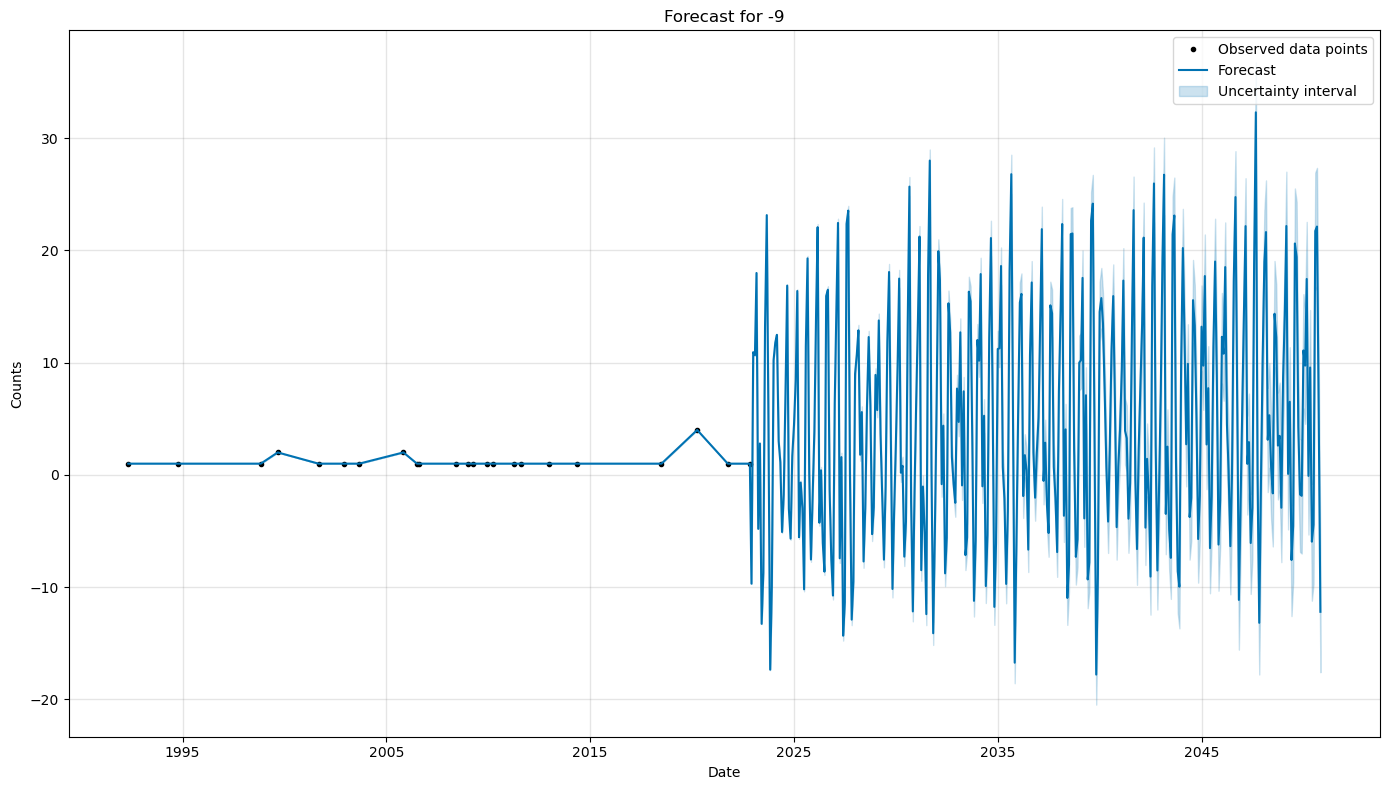

Dickey-Fuller Test Results:

Gender: Female
ADF Statistic: -2.98
p-value: 0.04
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: Male
ADF Statistic: -2.85
p-value: 0.05
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: -9
ADF Statistic: -5.02
p-value: 0.00
Critical Value 1%: -3.77
Critical Value 5%: -3.01
Critical Value 10%: -2.64

Actual Counts per Year (2013-2023):
Year 2013: 1185.00 counts
Year 2014: 1149.00 counts
Year 2015: 1206.00 counts
Year 2016: 1293.00 counts
Year 2017: 1223.00 counts
Year 2018: 1134.00 counts
Year 2019: 1186.00 counts
Year 2020: 1093.00 counts
Year 2021: 1128.00 counts
Year 2022: 1179.00 counts
Year 2023: 1270.00 counts


In [4]:
#WITHOUT HOLIDAYS
#WITHOUT HOLIDAYS
#WITHOUT HOLIDAYS
#WITHOUT HOLIDAYS
#WITHOUT HOLIDAYS
#WITHOUT HOLIDAYS



# Function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Filter data for 'Male' and 'Female' only
train_data = train_data[train_data['Gender'].isin(['Male', 'Female'])]
test_data = test_data[test_data['Gender'].isin(['Male', 'Female'])]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
        
        # Skip if there are less than 2 non-NaN rows
        if value_data.shape[0] < 2:
            print(f"Skipping {value} due to insufficient data.")
            continue

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=False,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Gender'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure there are actual counts for 2023
    if actual_counts_2023.shape[0] == 0:
        print(f"No actual data for {value} in 2023.")
        continue

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    #r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024.round(2))
    print()

    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    total_2030 = future_2030['yhat'].sum()
    total_2040 = future_2040['yhat'].sum()
    total_2050 = future_2050['yhat'].sum()

    print(f"Total forecasted counts for {value} in 2030: {total_2030:.2f}")
    print(f"Total forecasted counts for {value} in 2040: {total_2040:.2f}")
    print(f"Total forecasted counts for {value} in 2050: {total_2050:.2f}")
    print()
# Plot the forecasts in separate figures
for value, forecast in forecasts.items():
    fig, ax = plt.subplots(figsize=(14, 8))
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    #train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
   # test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Save the plot
    fig.savefig(f'{feature}_{value}_forecast.png')

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\n{feature}: {value}")
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, val in adf_result[4].items():
        print(f"Critical Value {key}: {val:.2f}")

# Print actual counts for each year from 2013 to 2023
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[(data['Year'] == year) & (data['Gender'].isin(['Male', 'Female']))].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum():.2f} counts")


23:42:54 - cmdstanpy - INFO - Chain [1] start processing
23:42:54 - cmdstanpy - INFO - Chain [1] done processing
23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:42:55 - cmdstanpy - INFO - Chain [1] done processing
23:42:55 - cmdstanpy - INFO - Chain [1] start processing
23:43:13 - cmdstanpy - INFO - Chain [1] done processing


Skipping Unspecified due to insufficient data.
Skipping M  due to insufficient data.
Skipping U due to insufficient data.
Evaluation Metrics for the Test Period (2023) - Gender:
Female - MAE: 3.85, MSE: 26.16, MAPE: 13.59%
Forecast vs Actual for first three months of 2024 for Female:
            ds   yhat  yhat_lower  yhat_upper
420 2024-01-01  21.74        8.88       34.14
421 2024-02-01  27.31        7.28       30.85
422 2024-03-01  25.51       13.05       37.87
        Date  Counts
0 2024-01-01      21
1 2024-02-01      31
2 2024-03-01      25

Forecast for Female in 2030:
            ds   yhat  yhat_lower  yhat_upper
493 2030-01-31  15.52        3.01       27.28
494 2030-02-28  25.58       13.23       38.34
495 2030-03-31  16.06        3.90       27.48
496 2030-04-30  19.14        7.62       32.24
497 2030-05-31  15.34        2.78       27.88
498 2030-06-30  24.37       12.00       36.97
499 2030-07-31  20.22        8.36       32.25
500 2030-08-31  17.17        5.29       28.61
501

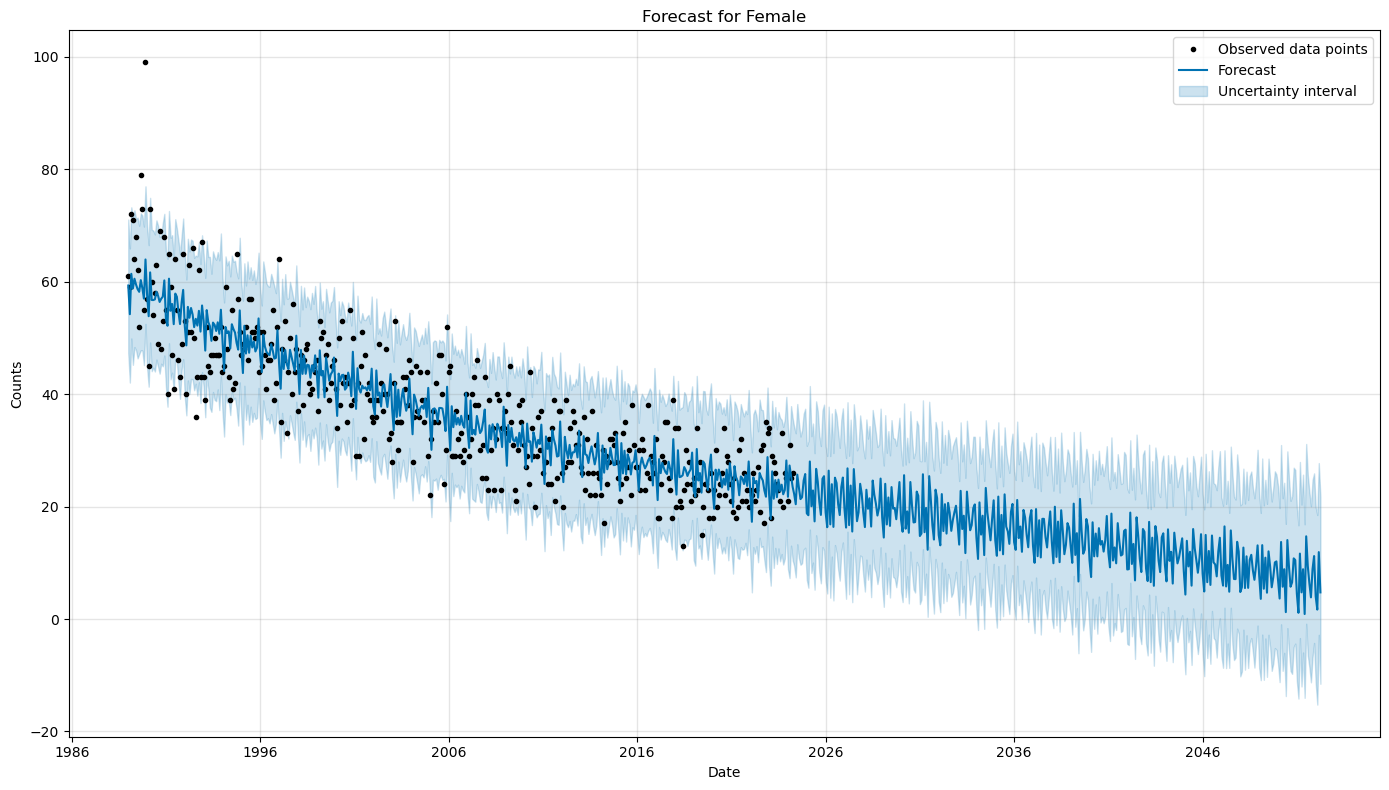

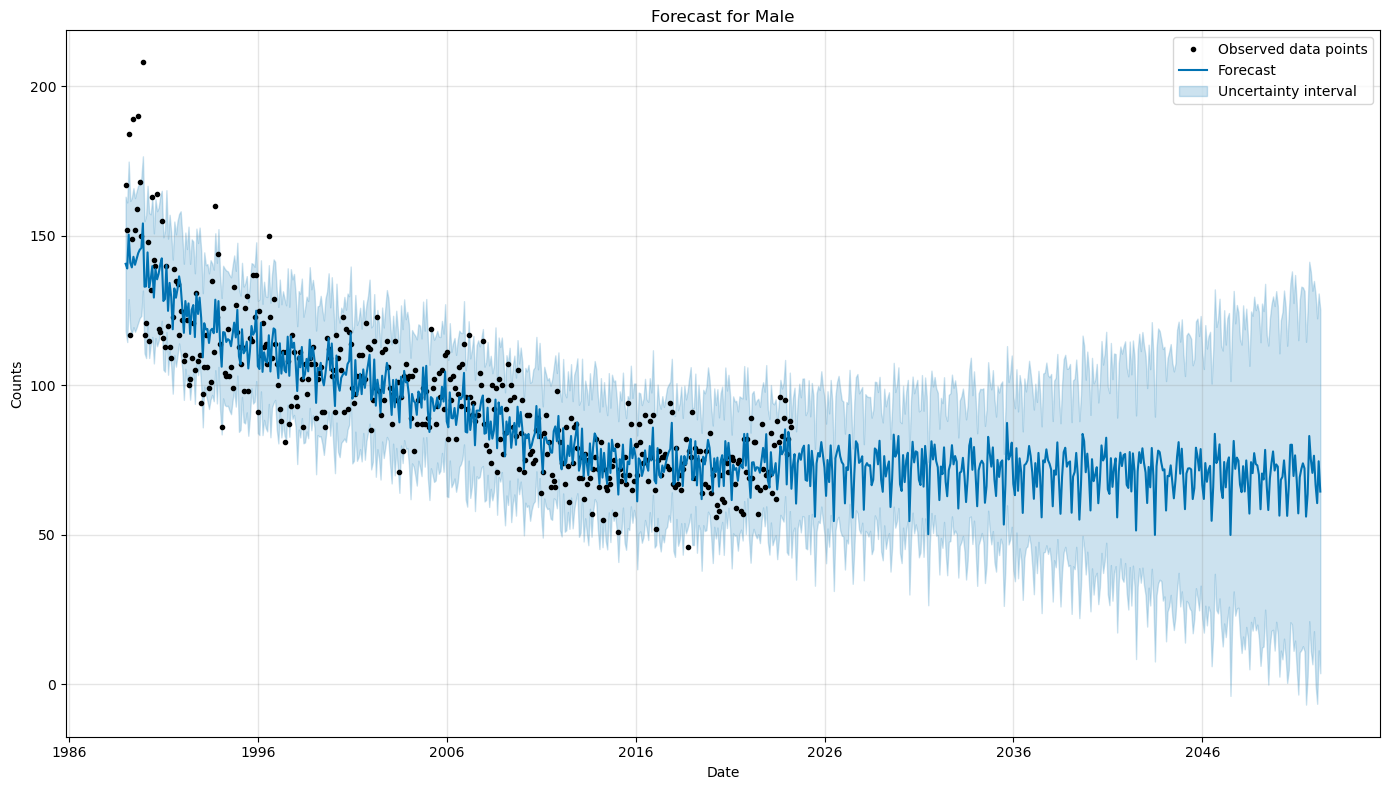

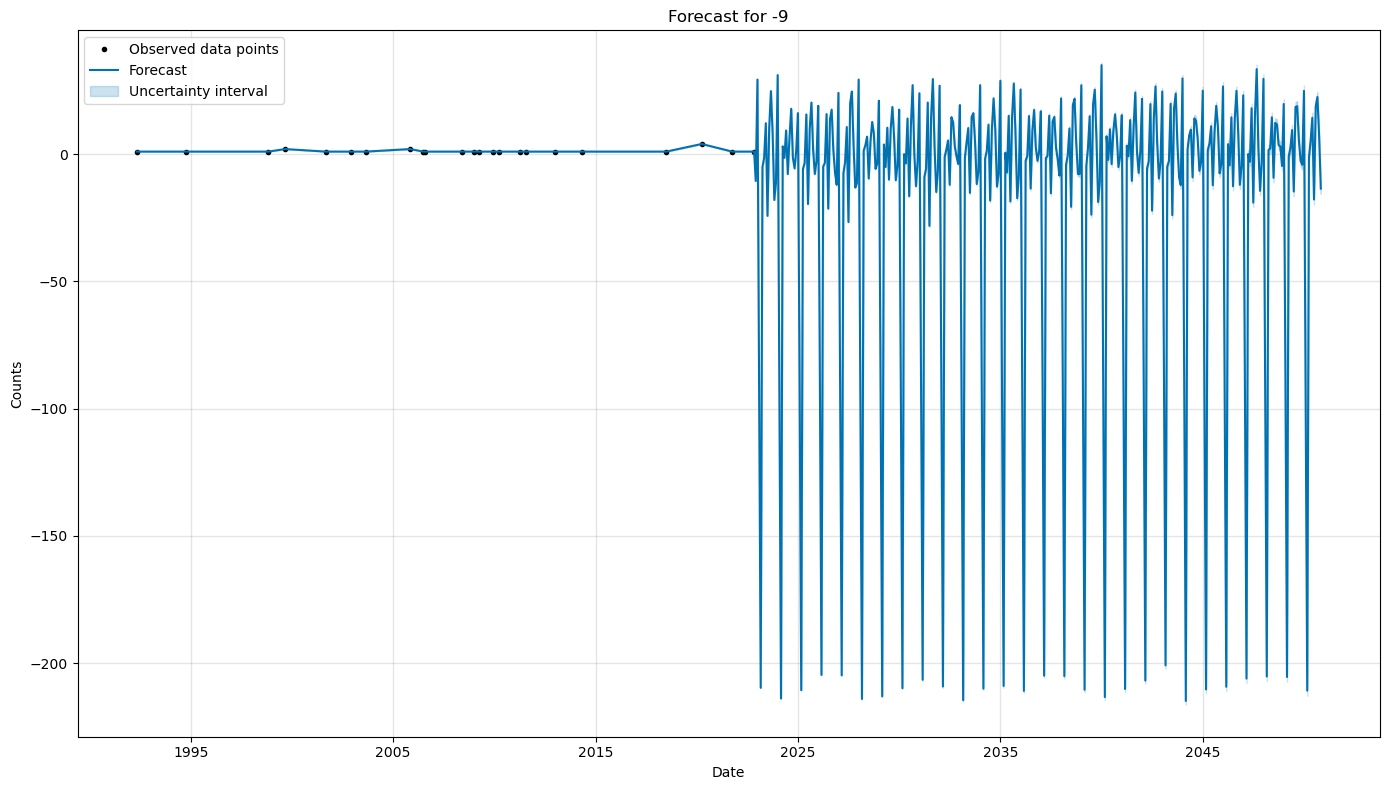

Dickey-Fuller Test Results:

Gender: Female
ADF Statistic: -2.98
p-value: 0.04
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: Male
ADF Statistic: -2.85
p-value: 0.05
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: -9
ADF Statistic: -5.02
p-value: 0.00
Critical Value 1%: -3.77
Critical Value 5%: -3.01
Critical Value 10%: -2.64

Actual Counts per Year (2013-2023):
Year 2013: 1185.00 counts
Year 2014: 1149.00 counts
Year 2015: 1206.00 counts
Year 2016: 1293.00 counts
Year 2017: 1223.00 counts
Year 2018: 1134.00 counts
Year 2019: 1186.00 counts
Year 2020: 1093.00 counts
Year 2021: 1128.00 counts
Year 2022: 1179.00 counts
Year 2023: 1270.00 counts


In [9]:

#technic for improve mounth 2 with mean 
#technic for improve mounth 2 with mean 
#technic for improve mounth 2 with mean 
#technic for improve mounth 2 with mean 
#technic for improve mounth 2 with mean 

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Filter data for 'Male' and 'Female' only
train_data = train_data[train_data['Gender'].isin(['Male', 'Female'])]
test_data = test_data[test_data['Gender'].isin(['Male', 'Female'])]

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
        
        # Skip if there are less than 2 non-NaN rows
        if value_data.shape[0] < 2:
            print(f"Skipping {value} due to insufficient data.")
            continue

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive')
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)

        # Adjust prediction for 1st February 2024
        forecast_2024_feb_1 = (forecast['ds'] == '2024-02-01')
        forecast.loc[forecast_2024_feb_1, 'yhat'] = forecast['yhat'].mean()
        
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Gender'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure there are actual counts for 2023
    if actual_counts_2023.shape[0] == 0:
        print(f"No actual data for {value} in 2023.")
        continue

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])


    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024.round(2))
    print()
    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    total_2030 = future_2030['yhat'].sum()
    total_2040 = future_2040['yhat'].sum()
    total_2050 = future_2050['yhat'].sum()


    print(f"Total forecasted counts for {value} in 2030: {total_2030:.2f}")
    print(f"Total forecasted counts for {value} in 2040: {total_2040:.2f}")
    print(f"Total forecasted counts for {value} in 2050: {total_2050:.2f}")
    print()
# Plot the forecasts in separate figures
for value, forecast in forecasts.items():
    fig, ax = plt.subplots(figsize=(14, 8))
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    #train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    #test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Save the plot
    #fig.savefig(f'{feature}_{value}_forecast.png')

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\n{feature}: {value}")
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, val in adf_result[4].items():
        print(f"Critical Value {key}: {val:.2f}")

# Print actual counts for each year from 2013 to 2023
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[(data['Year'] == year) & (data['Gender'].isin(['Male', 'Female']))].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum():.2f} counts")


23:56:49 - cmdstanpy - INFO - Chain [1] start processing
23:56:49 - cmdstanpy - INFO - Chain [1] done processing
23:56:50 - cmdstanpy - INFO - Chain [1] start processing
23:56:50 - cmdstanpy - INFO - Chain [1] done processing
23:56:50 - cmdstanpy - INFO - Chain [1] start processing
23:57:00 - cmdstanpy - INFO - Chain [1] done processing


Skipping Unspecified due to insufficient data.
Skipping M  due to insufficient data.
Skipping U due to insufficient data.
Evaluation Metrics for the Test Period (2023) - Gender:
Female - MAE: 3.84, MSE: 26.02, MAPE: 13.57%
Forecast vs Actual for first three months of 2024 for Female:
            ds   yhat  yhat_lower  yhat_upper
420 2024-01-01  21.72        9.47       33.44
421 2024-02-01  18.72        7.00       31.14
422 2024-03-01  25.57       13.61       38.52
        Date  Counts
0 2024-01-01      21
1 2024-02-01      31
2 2024-03-01      25

Forecast for Female in 2030:
            ds   yhat  yhat_lower  yhat_upper
493 2030-01-31  15.35        3.62       27.60
494 2030-02-28  25.41       13.64       38.21
495 2030-03-31  16.38        3.30       28.49
496 2030-04-30  18.96        6.49       31.62
497 2030-05-31  15.47        3.54       28.12
498 2030-06-30  23.97       11.81       36.29
499 2030-07-31  20.08        7.36       32.31
500 2030-08-31  17.21        4.84       28.99
501

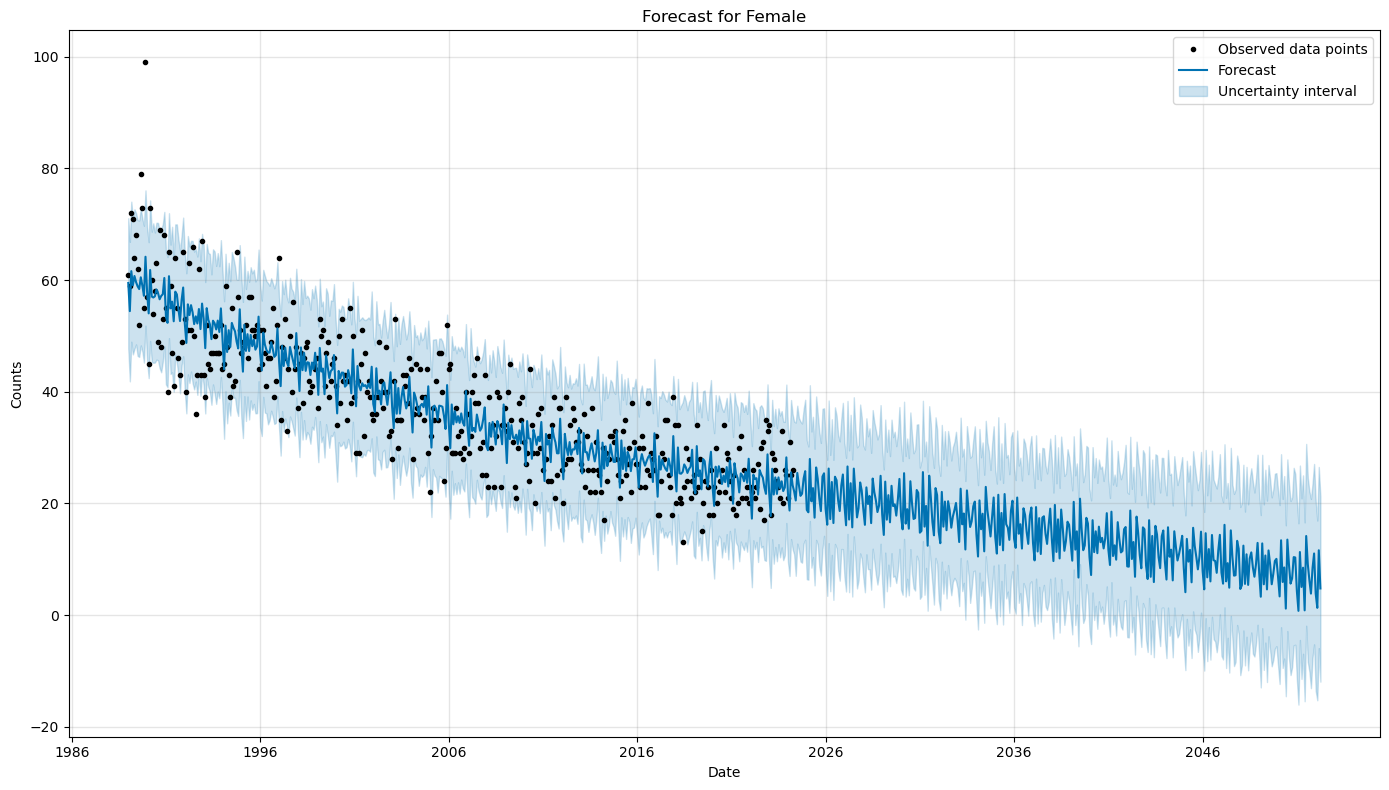

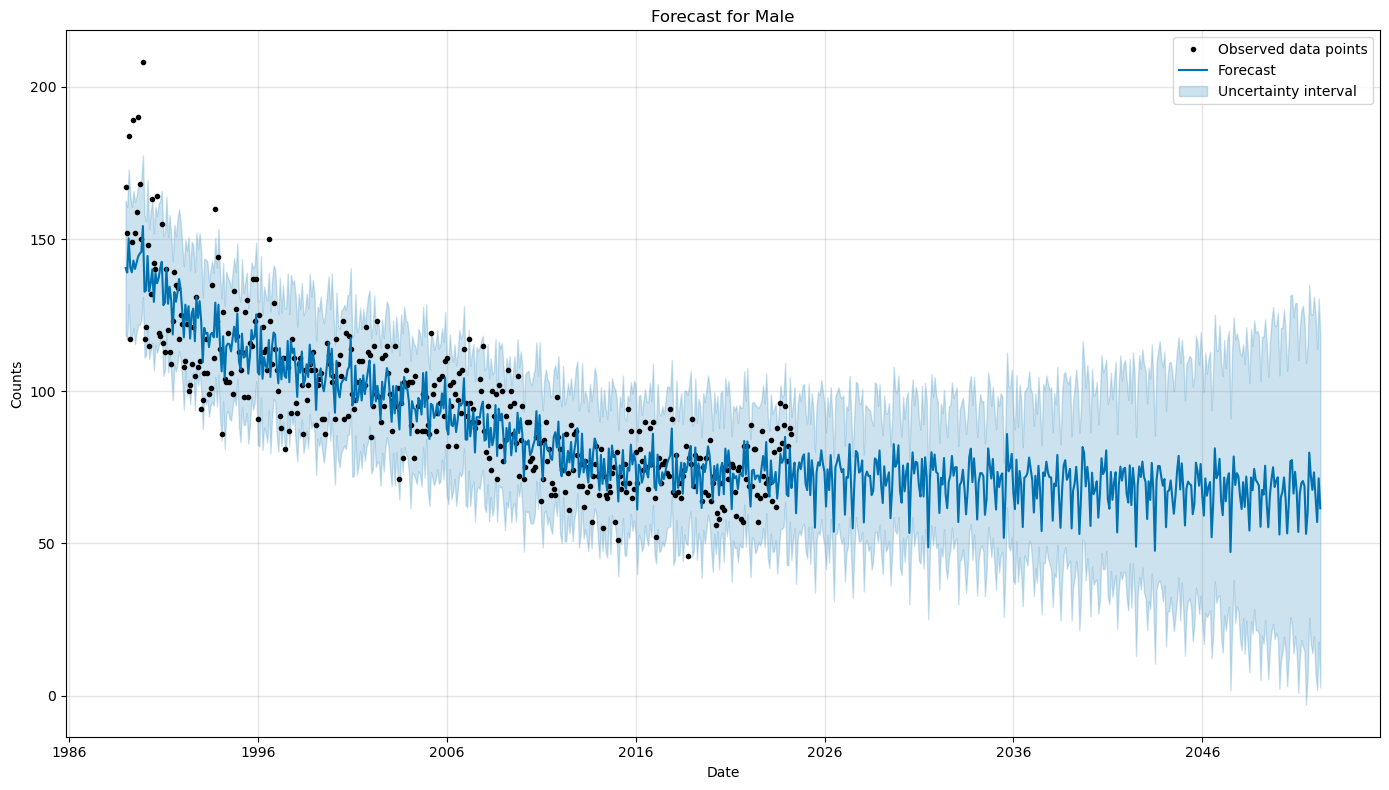

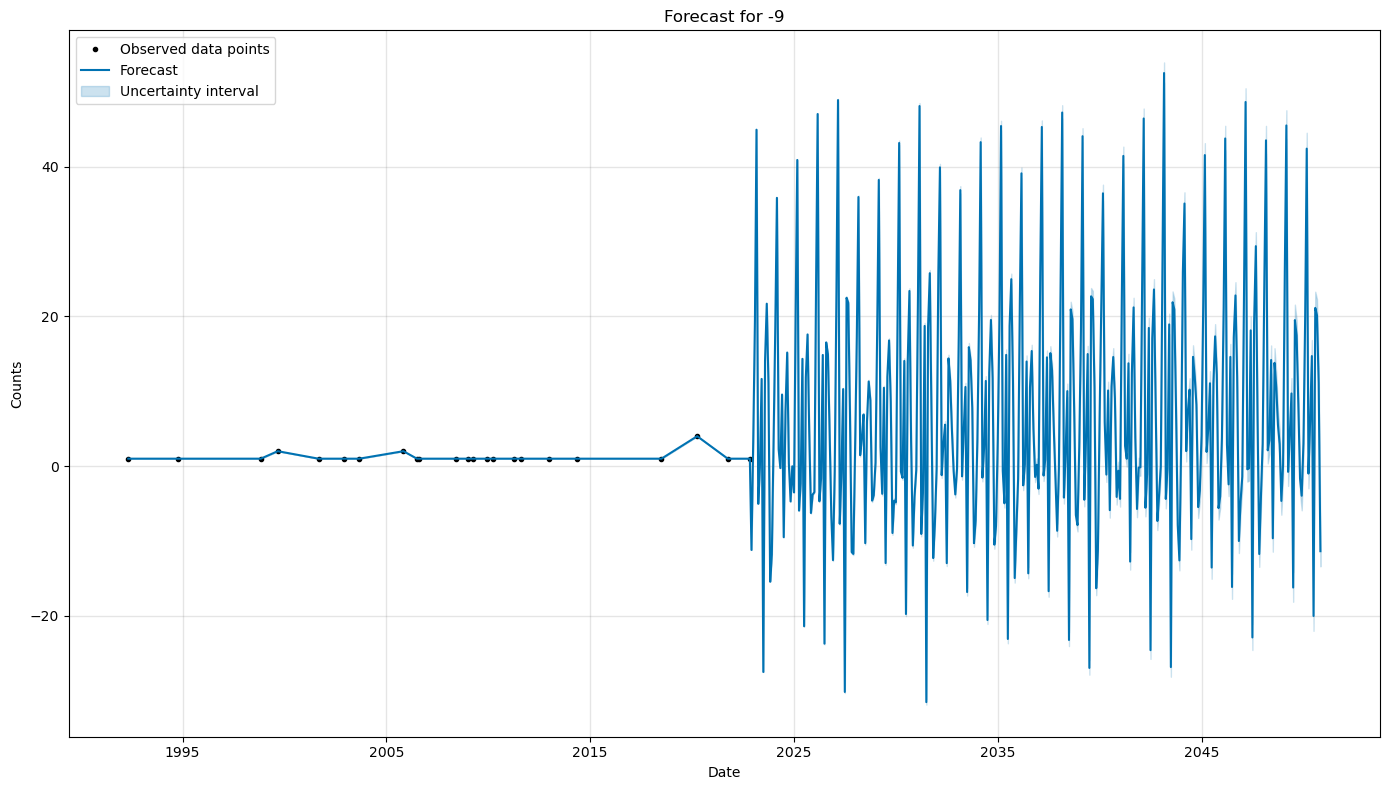

Dickey-Fuller Test Results:

Gender: Female
ADF Statistic: -2.98
p-value: 0.04
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: Male
ADF Statistic: -2.85
p-value: 0.05
Critical Value 1%: -3.45
Critical Value 5%: -2.87
Critical Value 10%: -2.57

Gender: -9
ADF Statistic: -5.02
p-value: 0.00
Critical Value 1%: -3.77
Critical Value 5%: -3.01
Critical Value 10%: -2.64

Actual Counts per Year (2013-2023):
Year 2013: 1185.00 counts
Year 2014: 1149.00 counts
Year 2015: 1206.00 counts
Year 2016: 1293.00 counts
Year 2017: 1223.00 counts
Year 2018: 1134.00 counts
Year 2019: 1186.00 counts
Year 2020: 1093.00 counts
Year 2021: 1128.00 counts
Year 2022: 1179.00 counts
Year 2023: 1270.00 counts


In [10]:
#Holiday with package
import holidays
#Holiday with package
#Holiday with package
#Holiday with package
#Holiday with package
#Holiday with package
#Holiday with package
#Holiday with package
#Holiday with package


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    return (abs((y_true - y_pred) / y_true)).mean() * 100

# Convert the 'Year' and 'Month' columns to a single datetime column
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

# Filter data up to 2022 for training and 2023 for testing
train_data = data[data['Year'] <= 2022]
test_data = data[data['Year'] == 2023]

# Filter data for 'Male' and 'Female' only
train_data = train_data[train_data['Gender'].isin(['Male', 'Female'])]
test_data = test_data[test_data['Gender'].isin(['Male', 'Female'])]

        
        # Add more holidays as needed

# Aggregate the number of occurrences of each feature per month for training data
def aggregate_counts(data, feature):
    return data.groupby(['Date', feature]).size().reset_index(name='Counts')

# Prepare the data for Prophet and forecast
def forecast_feature(data, feature):
    counts = aggregate_counts(data, feature)
    
    models = {}
    forecasts = {}
        # Create a dataframe for Australian holidays
    aus_holidays = holidays.Australia(years=range(1989, 2051))
    holidays_df = pd.DataFrame(list(aus_holidays.items()), columns=['ds', 'holiday'])
    
    for value in counts[feature].unique():
        value_data = counts[counts[feature] == value]
        value_data = value_data[['Date', 'Counts']].rename(columns={'Date': 'ds', 'Counts': 'y'})
        
        # Skip if there are less than 2 non-NaN rows
        if value_data.shape[0] < 2:
            print(f"Skipping {value} due to insufficient data.")
            continue

        # Initialize and fit the Prophet model
        model = Prophet(interval_width=0.95,
                        yearly_seasonality=True,
                        daily_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='additive',holidays=holidays_df)
        model.fit(value_data)
        models[value] = model

        # Create a dataframe for future dates including 2023 (test period) and beyond
        future_dates = model.make_future_dataframe(periods=(2050 - 2022) * 12, freq='M')

        # Predict future values
        forecast = model.predict(future_dates)
        forecasts[value] = forecast
    
    return models, forecasts

# Forecast for a specific feature
feature = 'Gender'  # Change this to the desired feature
time_of_day_models, forecasts = forecast_feature(data, feature)

# Calculate and print evaluation metrics for the test period (2023)
print(f"Evaluation Metrics for the Test Period (2023) - {feature}:")
for value, forecast in forecasts.items():
    # Filter forecast for 2023
    forecast_2023 = forecast[(forecast['ds'] >= '2023-01-01') & (forecast['ds'] <= '2023-12-31')]

    # Filter actual counts for 2023
    actual_counts_2023 = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    actual_counts_2023 = actual_counts_2023.rename(columns={'Date': 'ds', 'Counts': 'y'})

    # Ensure there are actual counts for 2023
    if actual_counts_2023.shape[0] == 0:
        print(f"No actual data for {value} in 2023.")
        continue

    # Ensure the forecast and actual data are aligned
    forecast_2023 = forecast_2023.set_index('ds').loc[actual_counts_2023['ds']].reset_index()

    # Calculate evaluation metrics
    mae = mean_absolute_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mse = mean_squared_error(actual_counts_2023['y'], forecast_2023['yhat'])
    mape = mean_absolute_percentage_error(actual_counts_2023['y'], forecast_2023['yhat'])
    #r2 = r2_score(actual_counts_2023['y'], forecast_2023['yhat'])

    print(f"{value} - MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")
    print(f"Forecast vs Actual for first three months of 2024 for {value}:")
    future_2024 = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
    print(future_2024[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))

    # Filter actual counts for first three months of 2024
    actual_counts_2024 = data[(data['Date'] >= '2024-01-01') & (data['Date'] <= '2024-03-31') & (data[feature] == value)]
    actual_counts_2024 = actual_counts_2024.groupby('Date').size().reset_index(name='Counts')
    print(actual_counts_2024.round(2))
    print()

    # Print forecast for 2030, 2040, and 2050
    # Print forecast for 2030, 2040, and 2050
    future_2030 = forecast[(forecast['ds'] >= '2030-01-01') & (forecast['ds'] <= '2030-12-31')]
    future_2040 = forecast[(forecast['ds'] >= '2040-01-01') & (forecast['ds'] <= '2040-12-31')]
    future_2050 = forecast[(forecast['ds'] >= '2050-01-01') & (forecast['ds'] <= '2050-12-31')]
    
    
    print(f"Forecast for {value} in 2030:")
    print(future_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2040:")
    print(future_2040[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    
    print(f"Forecast for {value} in 2050:")
    print(future_2050[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(2))
    print()
    total_2030 = future_2030['yhat'].sum()
    total_2040 = future_2040['yhat'].sum()
    total_2050 = future_2050['yhat'].sum()

    print(f"Total forecasted counts for {value} in 2030: {total_2030:.2f}")
    print(f"Total forecasted counts for {value} in 2040: {total_2040:.2f}")
    print(f"Total forecasted counts for {value} in 2050: {total_2050:.2f}")
    print()
# Plot the forecasts in separate figures
for value, forecast in forecasts.items():
    fig, ax = plt.subplots(figsize=(14, 8))
    model = time_of_day_models[value]
    model.plot(forecast, ax=ax, xlabel='Date', ylabel='Counts')
    
    # Plot training data
    #train_time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(train_time_data['Date'], train_time_data['Counts'], color='blue', s=10, label='Training Data')
    
    # Plot test data
    #test_time_data = test_data[test_data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    #ax.scatter(test_time_data['Date'], test_time_data['Counts'], color='red', s=10, label='Test Data')
    
    ax.legend()
    ax.set_title(f'Forecast for {value}')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Save the plot
    #fig.savefig(f'{feature}_{value}_forecast.png')

# Perform Dickey-Fuller Test
print("Dickey-Fuller Test Results:")
for value, forecast in forecasts.items():
    time_data = data[data[feature] == value].groupby('Date').size().reset_index(name='Counts')
    adf_result = adfuller(time_data['Counts'])
    print(f"\n{feature}: {value}")
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, val in adf_result[4].items():
        print(f"Critical Value {key}: {val:.2f}")

# Print actual counts for each year from 2013 to 2023
print("\nActual Counts per Year (2013-2023):")
for year in range(2013, 2024):
    year_counts = data[(data['Year'] == year) & (data['Gender'].isin(['Male', 'Female']))].groupby('Year').size().reset_index(name='Counts')
    print(f"Year {year}: {year_counts['Counts'].sum():.2f} counts")

